In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.preprocessing import StandardScaler

# 1. Synthetic data generation
def generate_synthetic_data(n_patients=100, n_timepoints=15):
    data = []
    ages = np.random.randint(20, 80, size=n_patients)
    sexes = np.random.choice([0, 1], size=n_patients)
    
    def generate_trajectory(age, sex):
        base = 13.5 if sex == 1 else 12.5
        age_effect = (80 - age) * 0.01
        setpoint = base + age_effect + np.random.normal(0, 0.3)
        trend = np.linspace(0, 1, n_timepoints)
        noise = np.random.normal(0, 0.2, size=n_timepoints)
        return setpoint + 0.5 * np.sin(trend * 2 * np.pi) + noise
    
    for i in range(n_patients):
        hemoglobin = generate_trajectory(ages[i], sexes[i])
        for t in range(n_timepoints):
            data


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.preprocessing import StandardScaler

# 1. Synthetic data generation
def generate_synthetic_data(n_patients=100, n_timepoints=15):
    data = []
    ages = np.random.randint(20, 80, size=n_patients)
    sexes = np.random.choice([0, 1], size=n_patients)
    
    def generate_trajectory(age, sex):
        base = 13.5 if sex == 1 else 12.5
        age_effect = (80 - age) * 0.01
        setpoint = base + age_effect + np.random.normal(0, 0.3)
        trend = np.linspace(0, 1, n_timepoints)
        noise = np.random.normal(0, 0.5, size=n_timepoints)
        return setpoint + 0.5 * np.sin(trend * 2 * np.pi) + noise
    
    for i in range(n_patients):
        hemoglobin = generate_trajectory(ages[i], sexes[i])
        for t in range(n_timepoints):
            data.append({
                'patient_id': i,
                'time': t,
                'hemoglobin': hemoglobin[t],
                'age': ages[i],
                'sex': sexes[i]
            })
    return pd.DataFrame(data)

df = generate_synthetic_data()

# 2. Dataset
class HemoglobinDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.patients = df['patient_id'].unique()
        self.scaler = StandardScaler()
        all_vals = df['hemoglobin'].values.reshape(-1, 1)
        self.scaler.fit(all_vals)
        
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        pid = self.patients[idx]
        patient_data = self.df[self.df['patient_id'] == pid]
        hemo = self.scaler.transform(patient_data['hemoglobin'].values.reshape(-1, 1)).flatten()
        age = patient_data['age'].values[0]
        sex = patient_data['sex'].values[0]
        times = patient_data['time'].values
        covariates = np.array([age / 100, sex])
        return torch.tensor(hemo, dtype=torch.float32), torch.tensor(times, dtype=torch.long), torch.tensor(covariates, dtype=torch.float32)

# 3. TimeVAE Model
class TimeVAE(pl.LightningModule):
    def __init__(self, seq_len, latent_dim=8, cov_dim=2, d_model=16):
        super().__init__()
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.cov_dim = cov_dim
        self.d_model = d_model

        self.embedding = nn.Linear(1 + cov_dim, d_model)
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=4)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=2)

        self.fc_mu = nn.Linear(d_model, latent_dim)
        self.fc_logvar = nn.Linear(d_model, latent_dim)

        self.decoder_input = nn.Linear(latent_dim + cov_dim, d_model)
        self.decoder = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def encode(self, x, covariates):
        x = x.unsqueeze(-1)
        cov = covariates.unsqueeze(1).repeat(1, x.size(1), 1)
        inp = torch.cat([x, cov], dim=-1)
        inp = self.embedding(inp)
        out = self.transformer_encoder(inp)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, covariates):
        cov = covariates.unsqueeze(1).repeat(1, z.size(1), 1)
        inp = torch.cat([z, cov], dim=-1)
        h = self.decoder_input(inp)
        return self.decoder(h).squeeze(-1)

    def forward(self, x, covariates):
        mu, logvar = self.encode(x, covariates)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, covariates)
        return recon_x, mu, logvar

    def sample_trajectories(self, x, covariates, n_samples=100):
        mu, logvar = self.encode(x, covariates)
        samples = []
        for _ in range(n_samples):
            z = self.reparameterize(mu, logvar)
            decoded = self.decode(z, covariates)
            samples.append(decoded.unsqueeze(0))
        return torch.cat(samples, dim=0)  # [n_samples, batch, seq]

    def training_step(self, batch, batch_idx):
        x, _, cov = batch
        recon_x, mu, logvar = self(x, cov)
        recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = recon_loss + 0.1 * kld
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# 4. Train the model
seq_len = df['time'].nunique()
dataset = HemoglobinDataset(df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

model = TimeVAE(seq_len=seq_len)
trainer = pl.Trainer(max_epochs=30, enable_checkpointing=False, logger=False)
trainer.fit(model, dataloader)

# 5. Inference with uncertainty (setpoint + 95% CI)
model.eval()
setpoint_means, setpoint_lowers, setpoint_uppers = [], [], []

with torch.no_grad():
    for x, _, cov in dataloader:
        samples = model.sample_trajectories(x, cov, n_samples=100)  # [100, B, T]
        mean_traj = samples.mean(dim=0)        # [B, T]
        lower = samples.quantile(0.025, dim=0) # [B, T]
        upper = samples.quantile(0.975, dim=0) # [B, T]
        
        setpoint = mean_traj.mean(dim=1)
        setpoint_low = lower.mean(dim=1)
        setpoint_high = upper.mean(dim=1)

        setpoint_means.append(setpoint)
        setpoint_lowers.append(setpoint_low)
        setpoint_uppers.append(setpoint_high)

# Combine results
setpoint_means = torch.cat(setpoint_means).cpu().numpy()
setpoint_lowers = torch.cat(setpoint_lowers).cpu().numpy()
setpoint_uppers = torch.cat(setpoint_uppers).cpu().numpy()

real_setpoints = dataset.scaler.inverse_transform(setpoint_means.reshape(-1, 1)).flatten()
real_lowers = dataset.scaler.inverse_transform(setpoint_lowers.reshape(-1, 1)).flatten()
real_uppers = dataset.scaler.inverse_transform(setpoint_uppers.reshape(-1, 1)).flatten()

# Display per-patient setpoint and uncertainty
for i in range(len(setpoint_means)):
    print(f"Patient {i:03}: Setpoint = {real_setpoints[i]:.2f}, "
          f"95% CI = [{real_lowers[i]:.2f}, {real_uppers[i]:.2f}]")


/opt/miniconda3/envs/labs_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | embedding           | Linear             | 64     | train
1 | transformer_encoder | TransformerEncoder | 137 K  | train
2 | fc_mu               | Linear             | 136    | train
3 | fc_logvar           | Linear             | 136    | train
4 | decoder_input       | Linear             | 176    | train
5 | decoder             | Sequential         | 577    | train
-------------------------------------------------------------------
138 K     Train

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Patient 000: Setpoint = 12.94, 95% CI = [12.82, 13.06]
Patient 001: Setpoint = 13.90, 95% CI = [13.78, 13.98]
Patient 002: Setpoint = 13.86, 95% CI = [13.73, 13.95]
Patient 003: Setpoint = 12.87, 95% CI = [12.75, 12.99]
Patient 004: Setpoint = 13.72, 95% CI = [13.59, 13.81]
Patient 005: Setpoint = 13.90, 95% CI = [13.78, 13.99]
Patient 006: Setpoint = 13.80, 95% CI = [13.68, 13.88]
Patient 007: Setpoint = 13.94, 95% CI = [13.82, 14.03]
Patient 008: Setpoint = 13.86, 95% CI = [13.75, 13.95]
Patient 009: Setpoint = 13.91, 95% CI = [13.79, 14.00]
Patient 010: Setpoint = 13.75, 95% CI = [13.62, 13.84]
Patient 011: Setpoint = 12.71, 95% CI = [12.59, 12.84]
Patient 012: Setpoint = 13.91, 95% CI = [13.79, 13.99]
Patient 013: Setpoint = 13.95, 95% CI = [13.83, 14.03]
Patient 014: Setpoint = 12.69, 95% CI = [12.56, 12.83]
Patient 015: Setpoint = 12.83, 95% CI = [12.72, 12.96]
Patient 016: Setpoint = 13.82, 95% CI = [13.70, 13.91]
Patient 017: Setpoint = 13.75, 95% CI = [13.62, 13.84]
Patient 01

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler


# 1. Synthetic data generation for setpoint + variation
def generate_synthetic_data(n_patients=100, n_timepoints=15):
    data = []
    ages = np.random.randint(20, 80, size=n_patients)
    sexes = np.random.choice([0, 1], size=n_patients)

    for i in range(n_patients):
        age = ages[i]
        sex = sexes[i]
        base = 13.5 if sex == 1 else 12.5
        age_effect = (80 - age) * 0.01
        setpoint = base + age_effect + np.random.normal(0, 0.3)
        variation = np.abs(np.random.normal(0.5, 0.2))  # person-level variation
        times = np.sort(np.random.uniform(0, 365 * 2, n_timepoints))
        values = np.random.normal(setpoint, variation, size=n_timepoints)
        for t, v in zip(times, values):
            data.append({
                'patient_id': i,
                'time': t,
                'hemoglobin': v,
                'age': age,
                'sex': sex
            })
    return pd.DataFrame(data)

df = generate_synthetic_data()

class SetpointDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.patients = df['patient_id'].unique()
        self.scaler = StandardScaler()
        all_vals = df['hemoglobin'].values.reshape(-1, 1)
        self.scaler.fit(all_vals)

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        pid = self.patients[idx]
        patient_data = self.df[self.df['patient_id'] == pid].sort_values('time')
        hemo = self.scaler.transform(patient_data['hemoglobin'].values.reshape(-1, 1)).flatten()

        time = patient_data['time'].values
        deltas = np.diff(time, prepend=0) / (365 * 2)  # normalize to [0, 1]

        features = np.stack([hemo, deltas], axis=1)  # shape = [T, 2]
        age = patient_data['age'].values[0] / 100
        sex = patient_data['sex'].values[0]
        covariates = np.array([age, sex])
        return (
            torch.tensor(features, dtype=torch.float32),  # [T, 2]
            torch.tensor(covariates, dtype=torch.float32)
        )

# 3. Minimal Setpoint Estimator VAE (LSTM encoder → μ and σ)
class SetpointVAE(pl.LightningModule):
    def __init__(self, input_dim=2, cov_dim=2, latent_dim=8):  # input_dim = 2 now
        super().__init__()
        self.latent_dim = latent_dim
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=32, batch_first=True)

        self.fc_mu_z = nn.Linear(32 + cov_dim, latent_dim)
        self.fc_logvar_z = nn.Linear(32 + cov_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cov_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # outputs [mu_Hgb, log_sigma_Hgb]
        )

    def encode(self, x, covariates):
        # x shape should be [B, T, 2]
        _, (h, _) = self.lstm(x)  # h: [1, B, 32]
        h = h.squeeze(0)
        hc = torch.cat([h, covariates], dim=1)
        mu = self.fc_mu_z(hc)
        logvar = self.fc_logvar_z(hc)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, covariates):
        mu_z, logvar_z = self.encode(x, covariates)
        z = self.reparameterize(mu_z, logvar_z)
        zc = torch.cat([z, covariates], dim=1)
        out = self.decoder(zc)
        mu_hgb = out[:, 0]
        log_sigma_hgb = out[:, 1]
        return mu_hgb, log_sigma_hgb, mu_z, logvar_z

    def training_step(self, batch, batch_idx):
        x, cov = batch
        mu_hgb, log_sigma_hgb, mu_z, logvar_z = self(x, cov)
        sigma_hgb = torch.exp(log_sigma_hgb)

        # Ground truth mean and std
        x_mean = x[:,:,0].mean(dim=1)  # Only use hemoglobin values, not time deltas
        x_std = x[:,:,0].std(dim=1)

        # Log-likelihood under predicted Normal(mu_hgb, sigma_hgb)
        recon_loss = ((mu_hgb - x_mean)**2 + (sigma_hgb - x_std)**2).mean()

        # KL divergence from z ~ N(mu, sigma) to N(0, I)
        kld = -0.5 * torch.mean(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())

        loss = recon_loss + 0.1 * kld
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


# 4. Train the model
dataset = SetpointDataset(df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=lambda x: (
    torch.nn.utils.rnn.pad_sequence([item[0] for item in x], batch_first=True),
    torch.stack([item[1] for item in x])
))
model = SetpointVAE()
trainer = pl.Trainer(max_epochs=30, enable_checkpointing=False, logger=False)
trainer.fit(model, dataloader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | lstm        | LSTM       | 4.6 K  | train
1 | fc_mu_z     | Linear     | 280    | train
2 | fc_logvar_z | Linear     | 280    | train
3 | decoder     | Sequential | 418    | train
---------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/opt/miniconda3/envs/labs_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Patient 000:
  Observed Hgb: [12.9  13.37 12.63 13.33 13.78 13.34 13.35 13.34 13.56 13.37 12.85 13.36
 13.28 13.44 12.88 13.34 13.63 13.35 12.79 13.34 12.08 13.41 11.75 13.36
 13.73 13.41 13.09 13.4  13.13 13.37]
  Count: 30, Observed Var: 0.19
  Predicted Setpoint: 13.13 g/dL (±1.96σ: [12.01, 14.24])
------------------------------------------------------------


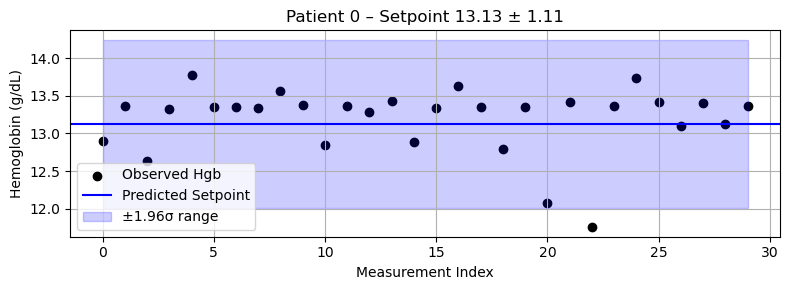

Patient 001:
  Observed Hgb: [13.29 13.34 13.42 13.32 13.33 13.42 13.48 13.32 13.33 13.34 13.21 13.34
 13.07 13.34 13.51 13.36 12.97 13.34 13.09 13.34 13.43 13.35 13.34 13.52
 13.59 13.39 13.24 13.34 13.48 13.4 ]
  Count: 30, Observed Var: 0.02
  Predicted Setpoint: 13.35 g/dL (±1.96σ: [12.21, 14.49])
------------------------------------------------------------


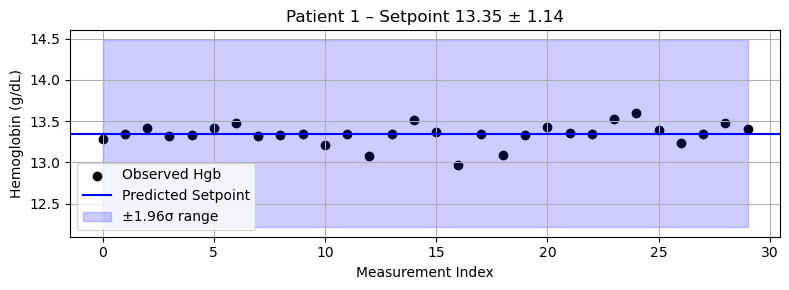

Patient 002:
  Observed Hgb: [12.91 13.34 12.26 13.35 12.85 13.37 12.88 13.37 12.38 13.4  13.45 13.39
 12.07 13.38 13.41 13.34 12.38 13.35 12.   13.4  12.3  13.33 11.85 13.42
 13.   13.4  11.54 13.36 13.36 13.33]
  Count: 30, Observed Var: 0.32
  Predicted Setpoint: 12.50 g/dL (±1.96σ: [11.61, 13.39])
------------------------------------------------------------


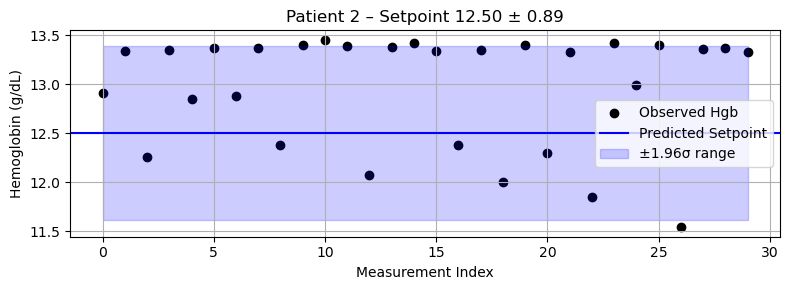

Patient 003:
  Observed Hgb: [13.83 13.39 13.55 13.32 14.31 13.36 14.05 13.33 13.66 13.39 13.82 13.32
 14.38 13.33 14.68 13.33 13.49 13.37 13.75 13.42 14.64 13.45 14.16 13.33
 12.87 13.43 13.21 13.39 13.23 13.34]
  Count: 30, Observed Var: 0.19
  Predicted Setpoint: 13.96 g/dL (±1.96σ: [12.92, 15.00])
------------------------------------------------------------


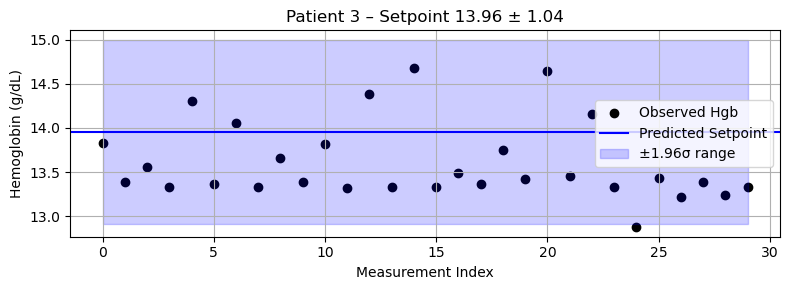

Patient 004:
  Observed Hgb: [13.47 13.32 12.36 13.36 12.95 13.48 12.39 13.34 12.71 13.35 11.09 13.35
 12.2  13.34 12.91 13.38 12.59 13.35 11.49 13.38 12.46 13.32 11.96 13.35
 11.91 13.32 11.55 13.35 12.78 13.38]
  Count: 30, Observed Var: 0.46
  Predicted Setpoint: 12.62 g/dL (±1.96σ: [11.71, 13.54])
------------------------------------------------------------


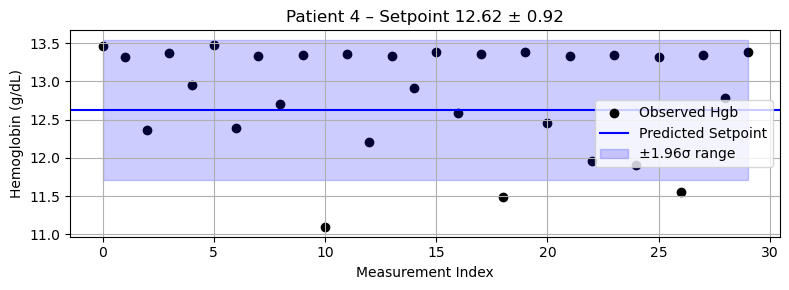

Patient 005:
  Observed Hgb: [12.66 13.33 14.16 13.44 13.42 13.33 13.19 13.32 12.23 13.41 15.76 13.35
 13.01 13.32 12.34 13.32 15.59 13.4  14.05 13.38 13.91 13.37 14.31 13.42
 14.43 13.32 14.22 13.33 12.63 13.35]
  Count: 30, Observed Var: 0.58
  Predicted Setpoint: 13.67 g/dL (±1.96σ: [12.62, 14.72])
------------------------------------------------------------
Patient 006:
  Observed Hgb: [11.7  13.42 11.76 13.32 12.51 13.32 11.86 13.37 11.97 13.34 11.71 13.33
 11.68 13.34 11.84 13.33 12.71 13.53 12.35 13.45 11.93 13.34 12.5  13.36
 12.06 13.36 12.59 13.39 12.9  13.34]
  Count: 30, Observed Var: 0.46
  Predicted Setpoint: 12.89 g/dL (±1.96σ: [11.88, 13.90])
------------------------------------------------------------
Patient 007:
  Observed Hgb: [13.4  13.32 12.33 13.47 12.14 13.38 12.04 13.33 12.6  13.35 12.67 13.39
 13.24 13.37 13.56 13.35 13.51 13.34 13.49 13.36 12.54 13.36 13.24 13.34
 12.66 13.37 13.35 13.35 13.06 13.35]
  Count: 30, Observed Var: 0.18
  Predicted Setpoint: 13.03

In [67]:
import matplotlib.pyplot as plt

model.eval()
scaler = dataset.scaler

for i in range(len(dataset)):
    x, cov = dataset[i]
    x_input = x.unsqueeze(0)
    cov_input = cov.unsqueeze(0)

    with torch.no_grad():
        mu_hgb, log_sigma_hgb, _, _ = model(x_input, cov_input)
        sigma_hgb = torch.exp(log_sigma_hgb).item()
        setpoint = mu_hgb.item()

    # inverse transform for plotting
    x_obs = scaler.inverse_transform(x_input[0].cpu().numpy().reshape(-1, 1)).flatten()
    setpoint_real = scaler.inverse_transform([[setpoint]])[0, 0]
    sigma_real = sigma_hgb * scaler.scale_[0]  # adjust std to original scale

    ci_low = setpoint_real - 1.96 * sigma_real
    ci_high = setpoint_real + 1.96 * sigma_real

    print(f"Patient {i:03}:")
    print(f"  Observed Hgb: {np.round(x_obs, 2)}")
    print(f"  Count: {len(x_obs)}, Observed Var: {np.var(x_obs):.2f}")
    print(f"  Predicted Setpoint: {setpoint_real:.2f} g/dL (±1.96σ: [{ci_low:.2f}, {ci_high:.2f}])")
    print("-" * 60)

    # Plot first few patients
    if i < 5:
        plt.figure(figsize=(8, 3))
        plt.scatter(range(len(x_obs)), x_obs, label='Observed Hgb', color='black')
        plt.axhline(setpoint_real, color='blue', label='Predicted Setpoint')
        plt.fill_between(range(len(x_obs)),
                         ci_low, ci_high,
                         color='blue', alpha=0.2, label='±1.96σ range')
        plt.title(f"Patient {i} – Setpoint {setpoint_real:.2f} ± {1.96 * sigma_real:.2f}")
        plt.xlabel("Measurement Index")
        plt.ylabel("Hemoglobin (g/dL)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


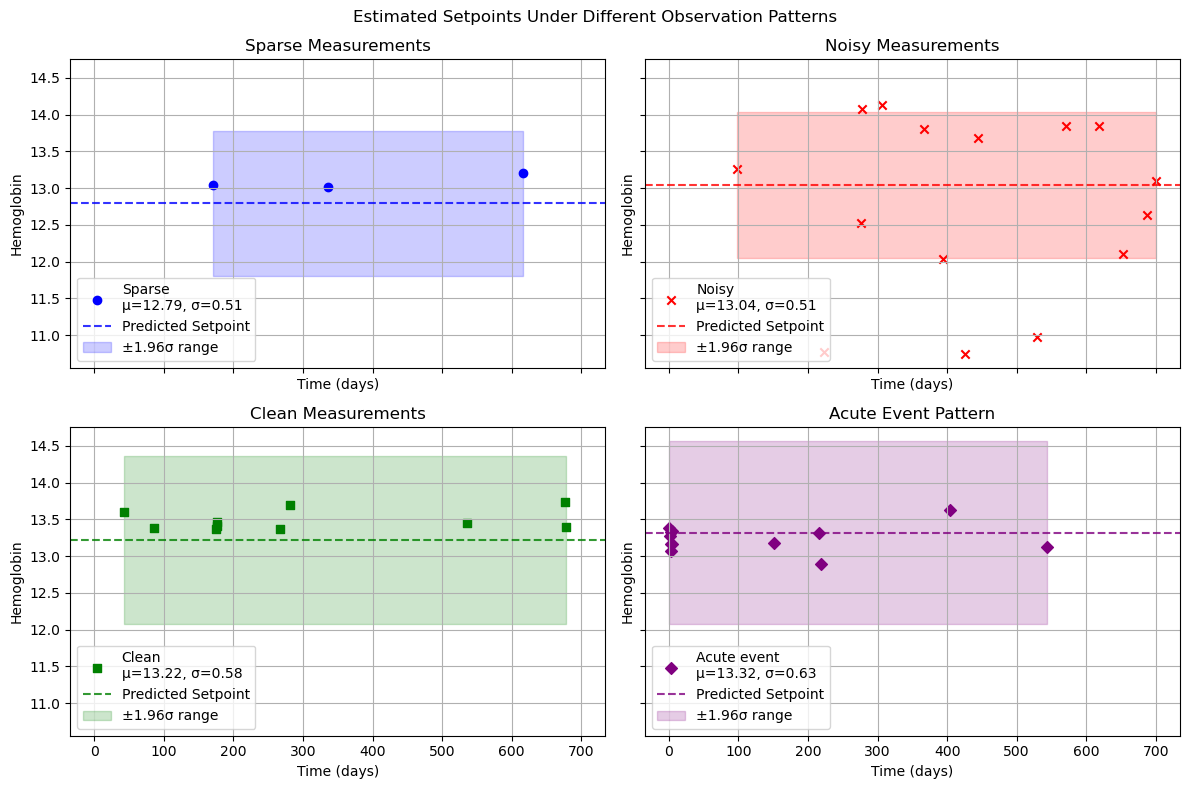

In [73]:
import matplotlib.pyplot as plt

def simulate_patient(times, setpoint, variation, age, sex, scaler):
    hemo = np.random.normal(setpoint, variation, size=len(times))
    hemo_scaled = scaler.transform(hemo.reshape(-1, 1)).flatten()
    deltas = np.diff(times, prepend=0) / (365 * 2)
    features = np.stack([hemo_scaled, deltas], axis=1)
    x_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)  # [1, T, 2]
    cov = torch.tensor([[age / 100, sex]], dtype=torch.float32)
    return x_tensor, cov, hemo, times

def evaluate_patient(x, cov, hemo, times, label, ax, color, marker):
    model.eval()
    with torch.no_grad():
        mu_hgb, log_sigma_hgb, _, _ = model(x, cov)
        
        mu = scaler.inverse_transform([[mu_hgb.item()]])[0,0]
        sigma = torch.exp(log_sigma_hgb).item() * scaler.scale_[0]
        
    # Plot measurements
    ax.scatter(times, hemo, marker=marker, color=color, label=f"{label}\nμ={mu:.2f}, σ={sigma:.2f}")
    
    # Plot setpoint
    ax.axhline(mu, color=color, linestyle='--', alpha=0.8, label='Predicted Setpoint')
    
    # Plot confidence interval
    ci_low = mu - 1.96 * sigma
    ci_high = mu + 1.96 * sigma
    ax.fill_between(times, [ci_low]*len(times), [ci_high]*len(times), 
                   color=color, alpha=0.2, label='±1.96σ range')
    return mu, sigma

scaler = dataset.scaler
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# 1. Sparse patient
x, cov, hemo, times = simulate_patient(
    times=np.sort(np.random.uniform(0, 365*2, 3)),  # 3 sparse
    setpoint=13.0, variation=0.3, age=50, sex=0, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Sparse", ax1, 'blue', 'o')
ax1.set_title("Sparse Measurements")

# 2. Noisy patient
x, cov, hemo, times = simulate_patient(
    times=np.sort(np.random.uniform(0, 365*2, 15)),
    setpoint=12.8, variation=1.5, age=60, sex=1, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Noisy", ax2, 'red', 'x')
ax2.set_title("Noisy Measurements")

# 3. Clean patient
x, cov, hemo, times = simulate_patient(
    times=np.sort(np.random.uniform(0, 365*2, 10)),
    setpoint=13.5, variation=0.1, age=40, sex=0, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Clean", ax3, 'green', 's')
ax3.set_title("Clean Measurements")

# 4. Acute event
acute_times = np.concatenate([np.sort(np.random.uniform(0, 5, 7)), np.sort(np.random.uniform(100, 730, 5))])
x, cov, hemo, times = simulate_patient(
    times=acute_times,
    setpoint=13.2, variation=0.3, age=65, sex=1, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Acute event", ax4, 'purple', 'D')
ax4.set_title("Acute Event Pattern")

# Set common labels and properties
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Hemoglobin")
    ax.grid(True)
    ax.legend()

plt.suptitle("Estimated Setpoints Under Different Observation Patterns")
plt.tight_layout()
plt.show()


In [105]:
class SetpointDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.patients = df['patient_id'].unique()
        self.scaler = StandardScaler()
        all_vals = df['hemoglobin'].values.reshape(-1, 1)
        self.scaler.fit(all_vals)

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        pid = self.patients[idx]
        patient_data = self.df[self.df['patient_id'] == pid].sort_values('time')
        hemo = self.scaler.transform(patient_data['hemoglobin'].values.reshape(-1, 1)).flatten()

        time = patient_data['time'].values
        norm_time = time / (365 * 2)  # normalize absolute time to [0, 1]

        features = np.stack([hemo, norm_time], axis=1)  # shape = [T, 2]
        age = patient_data['age'].values[0] / 100
        sex = patient_data['sex'].values[0]
        covariates = np.array([age, sex])
        return (
            torch.tensor(features, dtype=torch.float32),  # [T, 2]
            torch.tensor(covariates, dtype=torch.float32)
        )

class SetpointVAE(pl.LightningModule):
    def __init__(self, input_dim=1, cov_dim=2, latent_dim=8, time_embed_dim=8):
        super().__init__()
        self.latent_dim = latent_dim
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )

        # LSTM now receives hemoglobin + time_embedding
        self.lstm = nn.LSTM(input_size=1 + time_embed_dim, hidden_size=32, batch_first=True)

        self.fc_mu_z = nn.Linear(32 + cov_dim, latent_dim)
        self.fc_logvar_z = nn.Linear(32 + cov_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cov_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # outputs [mu_Hgb, log_sigma_Hgb]
        )

    def encode(self, x, covariates):
        hemo = x[:, :, 0:1]          # shape: [B, T, 1]
        time = x[:, :, 1:2]          # shape: [B, T, 1]
        time_embed = self.time_embed(time)  # [B, T, time_embed_dim]
        x_embed = torch.cat([hemo, time_embed], dim=2)  # [B, T, 1 + time_embed_dim]

        _, (h, _) = self.lstm(x_embed)  # h: [1, B, 32]
        h = h.squeeze(0)
        hc = torch.cat([h, covariates], dim=1)
        mu = self.fc_mu_z(hc)
        logvar = self.fc_logvar_z(hc)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, covariates):
        mu_z, logvar_z = self.encode(x, covariates)
        z = self.reparameterize(mu_z, logvar_z)
        zc = torch.cat([z, covariates], dim=1)
        out = self.decoder(zc)
        mu_hgb = out[:, 0]
        log_sigma_hgb = out[:, 1]
        return mu_hgb, log_sigma_hgb, mu_z, logvar_z

    def training_step(self, batch, batch_idx):
        x, cov = batch
        mu_hgb, log_sigma_hgb, mu_z, logvar_z = self(x, cov)
        sigma_hgb = torch.exp(log_sigma_hgb)

        x_mean = x[:, :, 0].mean(dim=1)
        x_std = x[:, :, 0].std(dim=1)

        recon_loss = ((mu_hgb - x_mean)**2 + (sigma_hgb - x_std)**2).mean()
        kld = -0.5 * torch.mean(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())

        loss = recon_loss + 0.1 * kld
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


# 4. Train the model
dataset = SetpointDataset(df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=lambda x: (
    torch.nn.utils.rnn.pad_sequence([item[0] for item in x], batch_first=True),
    torch.stack([item[1] for item in x])
))
model = SetpointVAE()
trainer = pl.Trainer(max_epochs=30, enable_checkpointing=False, logger=False)
trainer.fit(model, dataloader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | time_embed  | Sequential | 88     | train
1 | lstm        | LSTM       | 5.5 K  | train
2 | fc_mu_z     | Linear     | 280    | train
3 | fc_logvar_z | Linear     | 280    | train
4 | decoder     | Sequential | 418    | train
---------------------------------------------------
6.6 K     Trainable params
0         Non-trainable params
6.6 K     Total params
0.026     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
/opt/miniconda3/envs/labs_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve perf

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


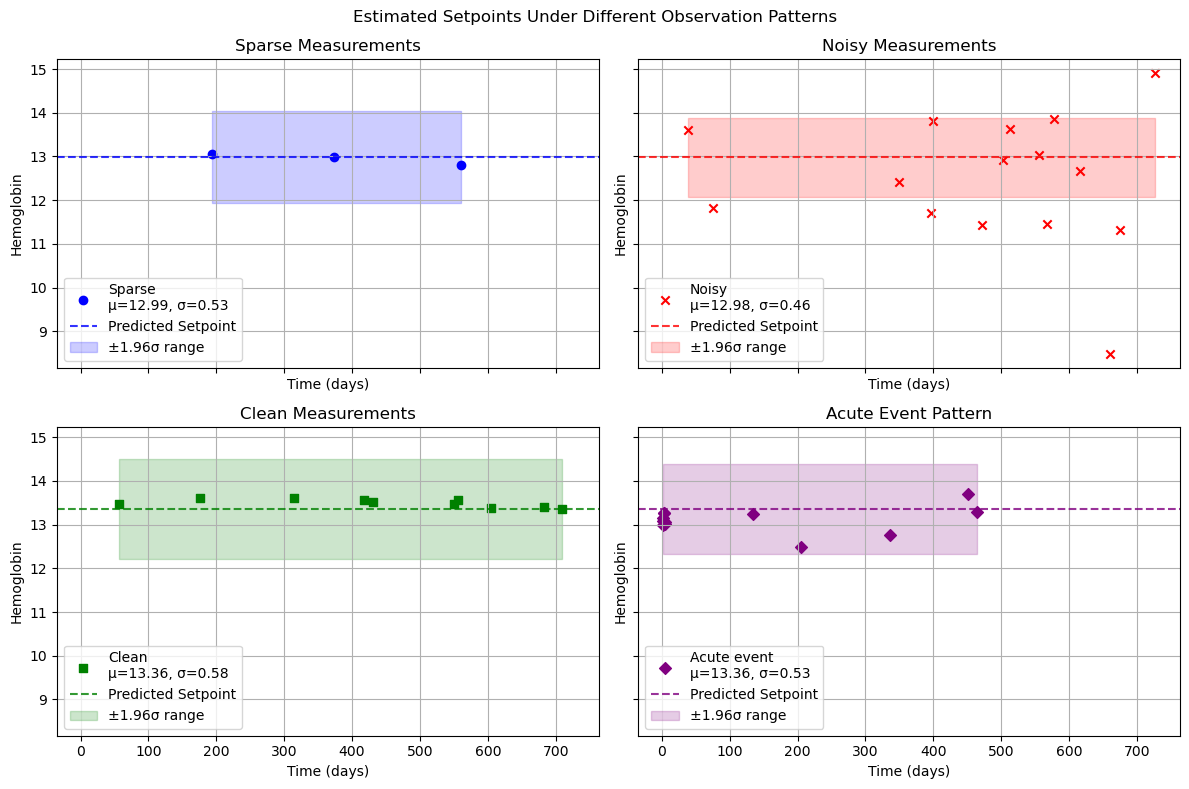

In [106]:
import matplotlib.pyplot as plt

def simulate_patient(times, setpoint, variation, age, sex, scaler):
    hemo = np.random.normal(setpoint, variation, size=len(times))
    hemo_scaled = scaler.transform(hemo.reshape(-1, 1)).flatten()
    deltas = np.diff(times, prepend=0) / (365 * 2)
    features = np.stack([hemo_scaled, deltas], axis=1)
    x_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)  # [1, T, 2]
    cov = torch.tensor([[age / 100, sex]], dtype=torch.float32)
    return x_tensor, cov, hemo, times

def evaluate_patient(x, cov, hemo, times, label, ax, color, marker):
    model.eval()
    with torch.no_grad():
        mu_hgb, log_sigma_hgb, _, _ = model(x, cov)
        
        mu = scaler.inverse_transform([[mu_hgb.item()]])[0,0]
        sigma = torch.exp(log_sigma_hgb).item() * scaler.scale_[0]
        
    # Plot measurements
    ax.scatter(times, hemo, marker=marker, color=color, label=f"{label}\nμ={mu:.2f}, σ={sigma:.2f}")
    
    # Plot setpoint
    ax.axhline(mu, color=color, linestyle='--', alpha=0.8, label='Predicted Setpoint')
    
    # Plot confidence interval
    ci_low = mu - 1.96 * sigma
    ci_high = mu + 1.96 * sigma
    ax.fill_between(times, [ci_low]*len(times), [ci_high]*len(times), 
                   color=color, alpha=0.2, label='±1.96σ range')
    return mu, sigma

scaler = dataset.scaler
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# 1. Sparse patient
x, cov, hemo, times = simulate_patient(
    times=np.sort(np.random.uniform(0, 365*2, 3)),  # 3 sparse
    setpoint=13.0, variation=0.3, age=50, sex=0, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Sparse", ax1, 'blue', 'o')
ax1.set_title("Sparse Measurements")

# 2. Noisy patient
x, cov, hemo, times = simulate_patient(
    times=np.sort(np.random.uniform(0, 365*2, 15)),
    setpoint=12.8, variation=1.5, age=60, sex=1, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Noisy", ax2, 'red', 'x')
ax2.set_title("Noisy Measurements")

# 3. Clean patient
x, cov, hemo, times = simulate_patient(
    times=np.sort(np.random.uniform(0, 365*2, 10)),
    setpoint=13.5, variation=0.1, age=40, sex=0, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Clean", ax3, 'green', 's')
ax3.set_title("Clean Measurements")

# 4. Acute event
acute_times = np.concatenate([np.sort(np.random.uniform(0, 5, 7)), np.sort(np.random.uniform(100, 730, 5))])
x, cov, hemo, times = simulate_patient(
    times=acute_times,
    setpoint=13.2, variation=0.3, age=65, sex=1, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Acute event", ax4, 'purple', 'D')
ax4.set_title("Acute Event Pattern")

# Set common labels and properties
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Hemoglobin")
    ax.grid(True)
    ax.legend()

plt.suptitle("Estimated Setpoints Under Different Observation Patterns")
plt.tight_layout()
plt.show()


In [98]:
class SetpointTransformerVAE(pl.LightningModule):
    def __init__(self, input_dim=1, cov_dim=2, latent_dim=8, time_embed_dim=8, nhead=2, nlayers=2):
        super().__init__()
        self.latent_dim = latent_dim
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )

        embed_dim = input_dim + time_embed_dim
        self.input_proj = nn.Linear(embed_dim, 32)

        encoder_layers = TransformerEncoderLayer(d_model=32, nhead=nhead, dim_feedforward=64)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=nlayers)

        self.fc_mu_z = nn.Linear(32 + cov_dim, latent_dim)
        self.fc_logvar_z = nn.Linear(32 + cov_dim, latent_dim)

        # Decoder now maps [z + covariates + time_embed] → [μ, logσ] per time step
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cov_dim + time_embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # outputs [μ_t, logσ_t]
        )

    def encode(self, x, covariates):
        hemo = x[:, :, 0:1]
        time = x[:, :, 1:2]
        time_embed = self.time_embed(time)
        x_embed = torch.cat([hemo, time_embed], dim=2)
        x_proj = self.input_proj(x_embed).permute(1, 0, 2)  # [T, B, D]
        encoded = self.transformer_encoder(x_proj).mean(dim=0)  # [B, D]
        hc = torch.cat([encoded, covariates], dim=1)
        mu = self.fc_mu_z(hc)
        logvar = self.fc_logvar_z(hc)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, covariates, time_embed):
        B, T, D = time_embed.shape
        zc = torch.cat([z.unsqueeze(1).expand(-1, T, -1),  # [B, T, latent]
                        covariates.unsqueeze(1).expand(-1, T, -1),  # [B, T, cov]
                        time_embed], dim=2)  # [B, T, D]
        out = self.decoder(zc)  # [B, T, 2]
        return out

    def forward(self, x, covariates):
        time = x[:, :, 1:2]
        time_embed = self.time_embed(time)  # [B, T, D]
        mu_z, logvar_z = self.encode(x, covariates)
        z = self.reparameterize(mu_z, logvar_z)
        decoded = self.decode(z, covariates, time_embed)
        mu_hgb_seq = decoded[:, :, 0]
        log_sigma_hgb_seq = decoded[:, :, 1]
        return mu_hgb_seq, log_sigma_hgb_seq, mu_z, logvar_z

    def training_step(self, batch, batch_idx):
        x, cov = batch
        mu_hgb_seq, log_sigma_hgb_seq, mu_z, logvar_z = self(x, cov)
        sigma_hgb_seq = torch.exp(log_sigma_hgb_seq)
        x_true = x[:, :, 0]

        # Full sequence NLL
        dist = torch.distributions.Normal(mu_hgb_seq, sigma_hgb_seq)
        log_likelihood = dist.log_prob(x_true)
        mask = ~torch.isnan(x_true)  # just in case of padding
        log_likelihood = log_likelihood[mask].mean()

        # KL
        kld = -0.5 * torch.mean(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())
        loss = -log_likelihood + 0.1 * kld
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


# 4. Train the model
dataset = SetpointDataset(df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=lambda x: (
    torch.nn.utils.rnn.pad_sequence([item[0] for item in x], batch_first=True),
    torch.stack([item[1] for item in x])
))
model = SetpointTransformerVAE()
trainer = pl.Trainer(max_epochs=30, enable_checkpointing=False, logger=False)
trainer.fit(model, dataloader)


/opt/miniconda3/envs/labs_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | time_embed          | Sequential         | 88     | train
1 | input_proj          | Linear             | 320    | train
2 | transformer_encoder | TransformerEncoder | 17.1 K | train
3 | fc_mu_z             | Linear             | 280    | train
4 | fc_logvar_z         | Linear             | 280    | train
5 | decoder             | Sequential         | 674    | train
-------------------------------------------------------------------
18.7 K    Trainable params
0         Non-trainable params
18.7 K    Total params
0.075     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode
/opt/miniconda3/envs/labs_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


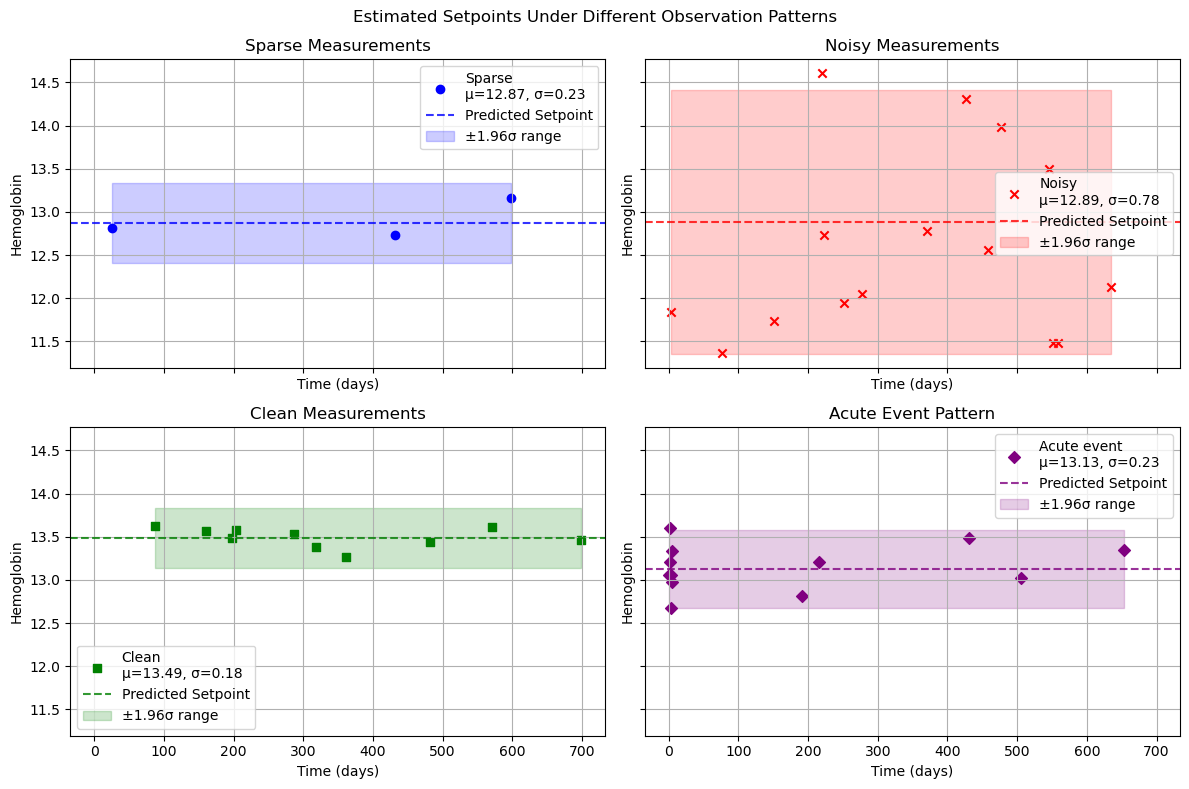

In [103]:
import matplotlib.pyplot as plt

def simulate_patient(times, setpoint, variation, age, sex, scaler):
    hemo = np.random.normal(setpoint, variation, size=len(times))
    hemo_scaled = scaler.transform(hemo.reshape(-1, 1)).flatten()
    deltas = np.diff(times, prepend=0) / (365 * 2)
    features = np.stack([hemo_scaled, deltas], axis=1)
    x_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)  # [1, T, 2]
    cov = torch.tensor([[age / 100, sex]], dtype=torch.float32)
    return x_tensor, cov, hemo, times

def evaluate_patient(x, cov, hemo, times, label, ax, color, marker):
    model.eval()
    with torch.no_grad():
        mu_hgb, log_sigma_hgb, _, _ = model(x, cov)

        mu_seq = mu_hgb[0].cpu().numpy()
        sigma_seq = torch.exp(log_sigma_hgb[0]).cpu().numpy()

        mu_mean = mu_seq.mean()
        sigma_mean = sigma_seq.mean()

        mu = scaler.inverse_transform([[mu_mean]])[0, 0]
        sigma = sigma_mean * scaler.scale_[0]
    
    # Plot measurements
    ax.scatter(times, hemo, marker=marker, color=color, label=f"{label}\nμ={mu:.2f}, σ={sigma:.2f}")
    
    # Plot setpoint
    ax.axhline(mu, color=color, linestyle='--', alpha=0.8, label='Predicted Setpoint')
    
    # Plot confidence interval
    ci_low = mu - 1.96 * sigma
    ci_high = mu + 1.96 * sigma
    ax.fill_between(times, [ci_low]*len(times), [ci_high]*len(times), 
                   color=color, alpha=0.2, label='±1.96σ range')
    return mu, sigma

scaler = dataset.scaler
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# 1. Sparse patient
x, cov, hemo, times = simulate_patient(
    times=np.sort(np.random.uniform(0, 365*2, 3)),  # 3 sparse
    setpoint=13.0, variation=0.3, age=50, sex=0, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Sparse", ax1, 'blue', 'o')
ax1.set_title("Sparse Measurements")

# 2. Noisy patient
x, cov, hemo, times = simulate_patient(
    times=np.sort(np.random.uniform(0, 365*2, 15)),
    setpoint=12.8, variation=1.5, age=60, sex=1, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Noisy", ax2, 'red', 'x')
ax2.set_title("Noisy Measurements")

# 3. Clean patient
x, cov, hemo, times = simulate_patient(
    times=np.sort(np.random.uniform(0, 365*2, 10)),
    setpoint=13.5, variation=0.1, age=40, sex=0, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Clean", ax3, 'green', 's')
ax3.set_title("Clean Measurements")

# 4. Acute event
acute_times = np.concatenate([np.sort(np.random.uniform(0, 5, 7)), np.sort(np.random.uniform(100, 730, 5))])
x, cov, hemo, times = simulate_patient(
    times=acute_times,
    setpoint=13.2, variation=0.3, age=65, sex=1, scaler=scaler
)
evaluate_patient(x, cov, hemo, times, "Acute event", ax4, 'purple', 'D')
ax4.set_title("Acute Event Pattern")

# Set common labels and properties
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Hemoglobin")
    ax.grid(True)
    ax.legend()

plt.suptitle("Estimated Setpoints Under Different Observation Patterns")
plt.tight_layout()
plt.show()
